# Visualización de Campo de Viento en Monterrey usando Open-Meteo API
Este notebook descarga datos de viento de la API de Open-Meteo para una grilla sobre el área metropolitana de Monterrey y grafica el campo de viento sobre un mapa.

In [9]:
# # Instalar librerías necesarias (si no están instaladas)
# !pip install requests cartopy matplotlib numpy pandas --quiet
# !pip install contextily geopandas shapely
# !pip install tqdm

In [10]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [11]:
# --- Declarar DataFrame de estaciones (df_estaciones) actualizado ---
data_estaciones = [
    {"station": "SE3", "lat": 25.60111, "lon": -99.9992},
    {"station": "SE2", "lat": 25.64583, "lon": -100.095},
    {"station": "NE3", "lat": 25.79056, "lon": -100.078},
    {"station": "SE", "lat": 25.66528, "lon": -100.244},
    {"station": "NE2", "lat": 25.77722, "lon": -100.188},
    {"station": "SUR", "lat": 25.61694, "lon": -100.274},
    {"station": "NE", "lat": 25.74472, "lon": -100.253},
    {"station": "NTE2", "lat": 25.72972, "lon": -100.31},
    {"station": "CE", "lat": 25.67583, "lon": -100.338},
    {"station": "NTE", "lat": 25.79861, "lon": -100.327},
    {"station": "NO", "lat": 25.76278, "lon": -100.369},
    {"station": "SO2", "lat": 25.665, "lon": -100.413},
    {"station": "SO", "lat": 25.67556, "lon": -100.458},
    {"station": "NO3", "lat": 25.76833, "lon": -100.464},
    {"station": "NO2", "lat": 25.80028, "lon": -100.584}
]
df_estaciones = pd.DataFrame(data_estaciones)


## 1. Definir la grilla de puntos sobre Monterrey
Usaremos una grilla de 4x4 puntos para ejemplo. Puedes aumentar la resolución si lo deseas.

In [12]:
# Coordenadas aproximadas del área metropolitana de Monterrey
lat_min, lat_max = 25.55, 25.80
lon_min, lon_max = -100.40, -100.00
n_lat, n_lon = 12, 12  # Aumenta la resolución de la grilla
lats = np.linspace(lat_min, lat_max, n_lat)
lons = np.linspace(lon_min, lon_max, n_lon)

## 2. Descargar datos de viento de Open-Meteo para cada punto de la grilla
Obtenemos la velocidad y dirección del viento para una hora específica.

In [13]:
from datetime import datetime, timedelta

fecha = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')  # ayer por defecto
hora = '12:00'  # UTC
wind_data = []
import time

for lat in lats:
    for lon in lons:
        url = f'https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=windspeed_10m,winddirection_10m&start_date={fecha}&end_date={fecha}&timezone=UTC'
        try:
            r = requests.get(url, timeout=10)  # Add 10 second timeout
            if r.status_code == 200:
                data = r.json()['hourly']
                # Buscar la hora deseada
                idx = data['time'].index(f'{fecha}T{hora}') if f'{fecha}T{hora}' in data['time'] else 0
                windspeed = data['windspeed_10m'][idx]
                winddir = data['winddirection_10m'][idx]
                wind_data.append({'lat': lat, 'lon': lon, 'windspeed': windspeed, 'winddir': winddir})
            else:
                wind_data.append({'lat': lat, 'lon': lon, 'windspeed': np.nan, 'winddir': np.nan})
        except requests.exceptions.RequestException as e:
            print(f"Error downloading data for lat={lat}, lon={lon}: {e}")
            wind_data.append({'lat': lat, 'lon': lon, 'windspeed': np.nan, 'winddir': np.nan})
        
        time.sleep(0.1)  # Small delay to avoid overwhelming the API
        
df_wind = pd.DataFrame(wind_data)

Error downloading data for lat=25.731818181818184, lon=-100.14545454545454: HTTPSConnectionPool(host='api.open-meteo.com', port=443): Read timed out. (read timeout=10)


KeyboardInterrupt: 

## 3. Convertir dirección y velocidad a componentes U y V (vectoriales)
Esto es necesario para graficar flechas de viento.

In [ ]:
# Dirección meteorológica: 0° = norte, 90° = este
df_wind['u'] = -df_wind['windspeed'] * np.sin(np.deg2rad(df_wind['winddir']))
df_wind['v'] = -df_wind['windspeed'] * np.cos(np.deg2rad(df_wind['winddir']))

## 4. Graficar el campo de viento sobre el mapa de Monterrey
Se usa cartopy para el mapa base y matplotlib para los vectores.

In [ ]:
#!pip install contextily geopandas shapely

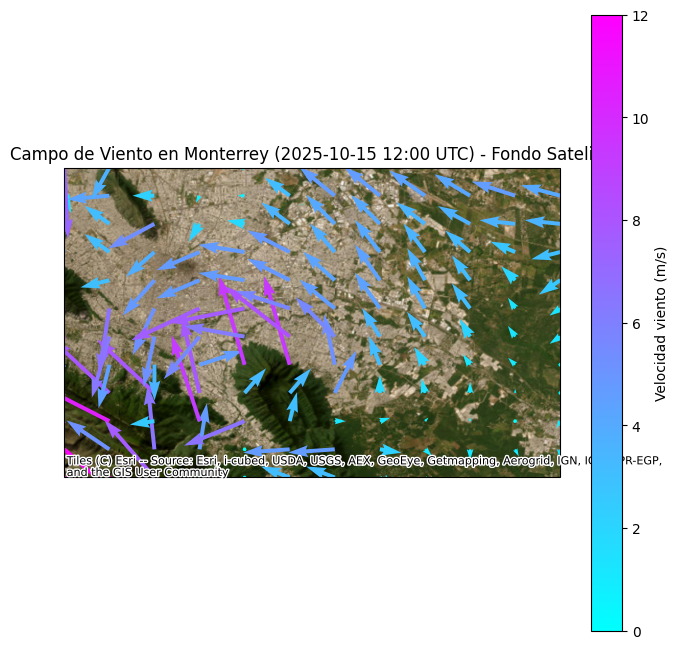

In [ ]:
# Para fondo satelital, usamos contextily (requiere instalarlo y usar CRS Web Mercator)
# Si no tienes contextily, instala con: !pip install contextily
import contextily as ctx

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Convertir a Web Mercator para contextily
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(df_wind, geometry=[Point(xy) for xy in zip(df_wind['lon'], df_wind['lat'])], crs='EPSG:4326')
gdf_web = gdf.to_crs(epsg=3857)

# Crear scatter invisible para ajustar límites
ax.scatter(df_wind['lon'], df_wind['lat'], alpha=0)

# Añadir fondo satelital
ax = plt.gca()
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Esri.WorldImagery)

# Graficar vectores de viento (en coordenadas originales)
q = ax.quiver(df_wind['lon'], df_wind['lat'], df_wind['u'], df_wind['v'], df_wind['windspeed'], cmap='cool', scale=50, width=0.008, transform=ccrs.PlateCarree())
plt.colorbar(q, ax=ax, label='Velocidad viento (m/s)')
plt.title(f'Campo de Viento en Monterrey ({fecha} {hora} UTC) - Fondo Satelital')
plt.show()

In [ ]:
# --- BLOQUE 1: Descargar datos históricos de viento usando el endpoint correcto de Open-Meteo (grilla más grande, enero) ---
import calendar
from tqdm.notebook import tqdm
import requests
import numpy as np
import pandas as pd

# Grilla más grande para mejor visualización
lat_min, lat_max = 25.55, 25.80
lon_min, lon_max = -100.40, -100.00
n_lat, n_lon = 10, 10  # Grilla 10x10
lats = np.linspace(lat_min, lat_max, n_lat)
lons = np.linspace(lon_min, lon_max, n_lon)

anio = 2024
mes = 1
fecha_inicio = f"{anio}-{mes:02d}-01"
fecha_fin = f"{anio}-{mes:02d}-31"

df_wind_all = []
descargas = 0
fallas = 0

for lat in lats:
    for lon in lons:
        url = (
            f"https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={lat}&longitude={lon}"
            f"&start_date={fecha_inicio}&end_date={fecha_fin}"
            f"&hourly=wind_speed_10m,wind_direction_10m"
            f"&timezone=America/Monterrey"
            f"&wind_speed_unit=ms"
            f"&format=json"
        )
        try:
            r = requests.get(url, timeout=10)  # Add 10 second timeout
            if r.status_code == 200:
                data = r.json().get('hourly', {})
                times = data.get('time', [])
                ws = data.get('wind_speed_10m', [])
                wd = data.get('wind_direction_10m', [])
                if times and ws and wd:
                    for t, wss, wdd in zip(times, ws, wd):
                        df_wind_all.append({
                            'lat': lat, 'lon': lon, 'time': t, 'windspeed': wss, 'winddir': wdd
                        })
                    descargas += 1
                else:
                    fallas += 1
            else:
                fallas += 1
        except requests.exceptions.RequestException as e:
            print(f"Error downloading data for lat={lat}, lon={lon}: {e}")
            fallas += 1
        
        time.sleep(0.1)  # Small delay to avoid overwhelming the API

print(f"Puntos descargados: {descargas}, fallas: {fallas}")

wind_df = pd.DataFrame(df_wind_all)
if not wind_df.empty:
    wind_df['u'] = -wind_df['windspeed'] * np.sin(np.deg2rad(wind_df['winddir']))
    wind_df['v'] = -wind_df['windspeed'] * np.cos(np.deg2rad(wind_df['winddir']))
    wind_df['mes'] = mes
    wind_monthly = wind_df.groupby(['lat', 'lon', 'mes']).agg({'u':'mean', 'v':'mean', 'windspeed':'mean'}).reset_index()
else:
    wind_monthly = pd.DataFrame(columns=['lat','lon','mes','u','v','windspeed'])

Puntos descargados: 100, fallas: 0


## 5. Visualización de campo de viento mensual para 3 meses
Se repetirá el proceso de descarga y visualización para enero, febrero y marzo, mostrando los 3 mapas en un solo grid.

Descargando y graficando año 2021...


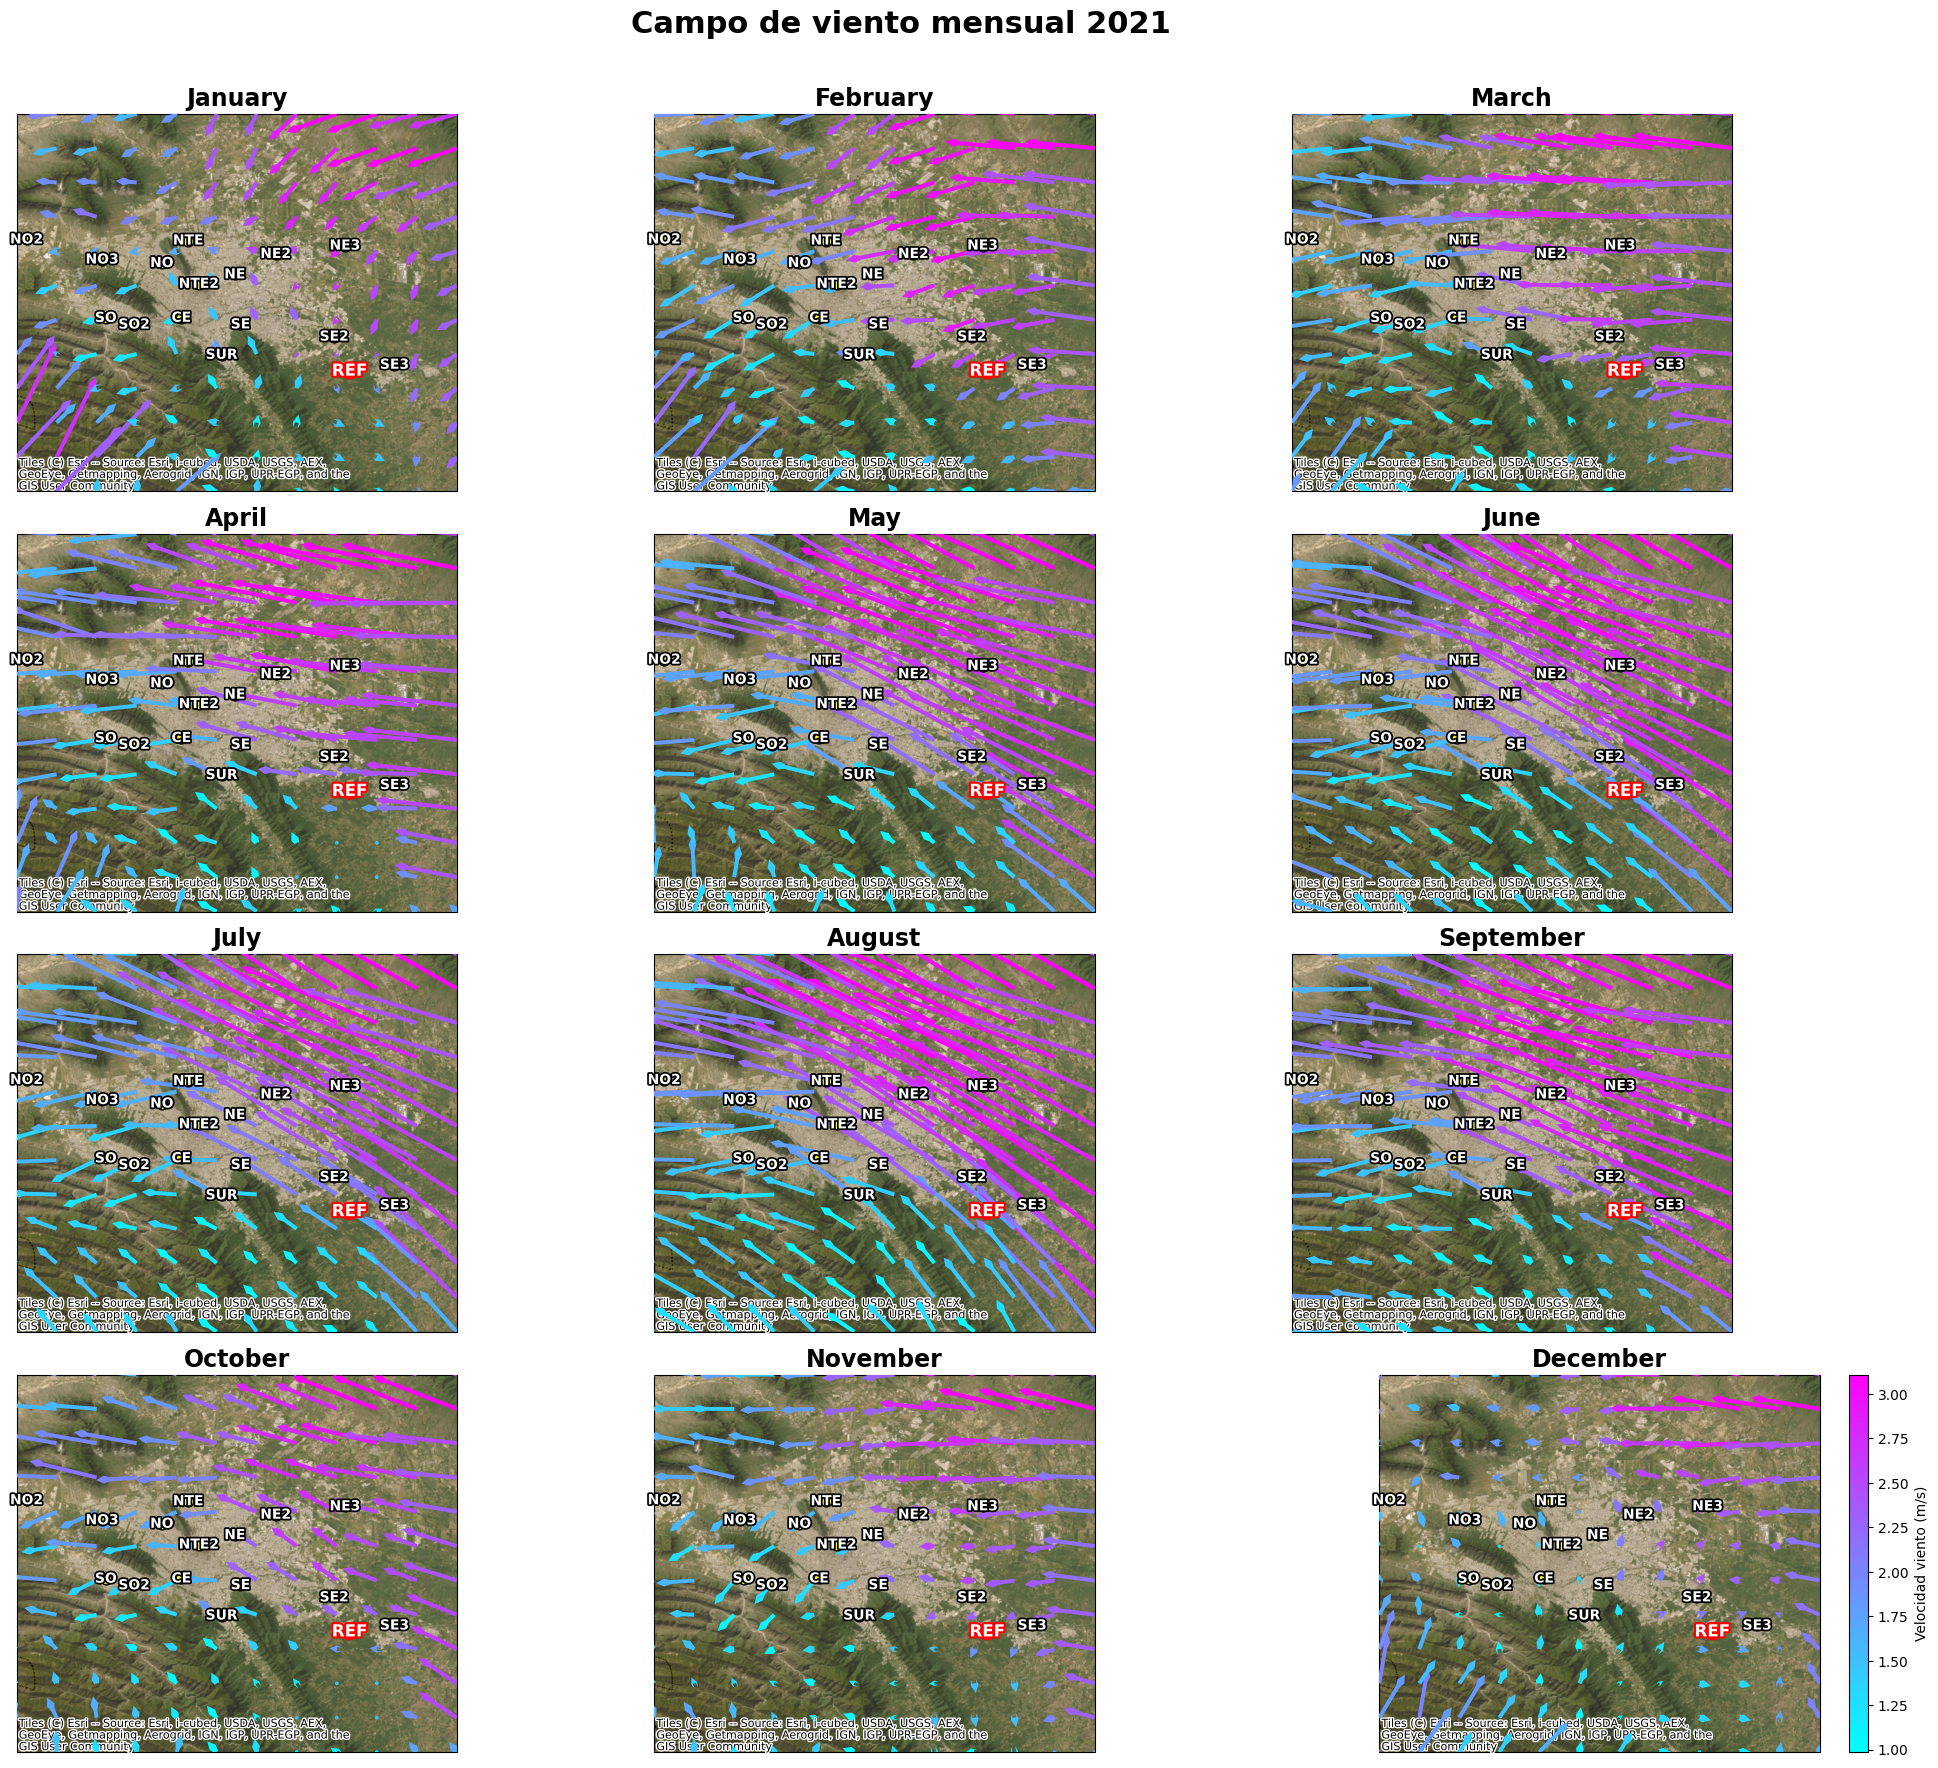

In [ ]:
# --- BLOQUE 4: Visualización anual para 2021 con tag de la refinería de Cadereyta y etiquetas de estaciones en negro/blanco ---
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx
import calendar
import numpy as np
import pandas as pd
import requests
import matplotlib.patheffects as PathEffects

# Coordenadas de la refinería de Cadereyta
ref_lat, ref_lon = 25.5917, -100.0706

# Rango ampliado para incluir todas las estaciones
lat_min, lat_max = 25.40, 26.00
lon_min, lon_max = -100.60, -99.90
n_lat, n_lon = 12, 12
lats = np.linspace(lat_min, lat_max, n_lat)
lons = np.linspace(lon_min, lon_max, n_lon)

anio = 2021
meses = list(range(1, 13))
wind_monthly_all = []
print(f"Descargando y graficando año {anio}...")
for mes in meses:
    fecha_inicio = f"{anio}-{mes:02d}-01"
    fecha_fin = f"{anio}-{mes:02d}-{calendar.monthrange(anio, mes)[1]}"
    df_wind_all = []
    for lat in lats:
        for lon in lons:
            # Para 2021, variables antiguas
            wind_speed_var = "windspeed_10m"
            wind_dir_var = "winddirection_10m"
            url = (
                f"https://archive-api.open-meteo.com/v1/archive?"
                f"latitude={lat}&longitude={lon}"
                f"&start_date={fecha_inicio}&end_date={fecha_fin}"
                f"&hourly={wind_speed_var},{wind_dir_var}"
                f"&timezone=America/Monterrey"
                f"&wind_speed_unit=ms"
                f"&format=json"
            )
            try:
                r = requests.get(url, timeout=10)  # Add 10 second timeout
                if r.status_code == 200:
                    data = r.json().get('hourly', {})
                    times = data.get(wind_speed_var, [])
                    ws = data.get(wind_speed_var, [])
                    wd = data.get(wind_dir_var, [])
                    if times and ws and wd:
                        for t, wss, wdd in zip(data.get('time', []), ws, wd):
                            df_wind_all.append({
                                'lat': lat, 'lon': lon, 'time': t, 'windspeed': wss, 'winddir': wdd, 'mes': mes
                            })
            except requests.exceptions.RequestException as e:
                print(f"Error downloading data for lat={lat}, lon={lon}, mes={mes}: {e}")
            
            time.sleep(0.1)  # Small delay to avoid overwhelming the API
    wind_df = pd.DataFrame(df_wind_all)
    if not wind_df.empty:
        wind_df['u'] = -wind_df['windspeed'] * np.sin(np.deg2rad(wind_df['winddir']))
        wind_df['v'] = -wind_df['windspeed'] * np.cos(np.deg2rad(wind_df['winddir']))
        wind_monthly = wind_df.groupby(['lat', 'lon', 'mes']).agg({'u':'mean', 'v':'mean', 'windspeed':'mean'}).reset_index()
        wind_monthly_all.append(wind_monthly)
    else:
        wind_monthly_all.append(pd.DataFrame(columns=['lat','lon','mes','u','v','windspeed']))
# Concatenar todos los meses
df_anio = pd.concat(wind_monthly_all, ignore_index=True)
# Visualización
ncols = 3
nrows = int(np.ceil(len(meses)/ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(21, 4.5*nrows), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()
for idx, mes in enumerate(meses):
    ax = axs[idx]
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='beige', zorder=0)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
    ax.add_feature(cfeature.COASTLINE, zorder=1)
    ax.add_feature(cfeature.STATES, linestyle=':', zorder=1)
    try:
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Esri.WorldImagery, alpha=0.8, zorder=2)
    except Exception:
        pass
    df_mes = df_anio[df_anio['mes'] == mes] if not df_anio.empty else pd.DataFrame()
    if not df_mes.empty:
        step = 1
        q = ax.quiver(df_mes['lon'][::step], df_mes['lat'][::step], df_mes['u'][::step], df_mes['v'][::step], df_mes['windspeed'][::step],
                      cmap='cool', scale=10, width=0.009, headwidth=2, headlength=2, headaxislength=3.5, zorder=3)
        if idx == len(meses)-1:
            cbar = plt.colorbar(q, ax=ax, label='Velocidad viento (m/s)', orientation='vertical', fraction=0.045, pad=0.04)
            cbar.ax.tick_params(labelsize=10)
    else:
        ax.text(0.5, 0.5, 'Sin datos de viento', transform=ax.transAxes, fontsize=16, color='red', ha='center', va='center', zorder=20)
    # Estaciones
    try:
        if 'df_estaciones' in globals() and not df_estaciones.empty:
            ax.scatter(df_estaciones['lon'], df_estaciones['lat'], color='yellow', edgecolor='black', s=60, marker='o', transform=ccrs.PlateCarree(), zorder=10)
            for i, row in df_estaciones.iterrows():
                txt = ax.text(row['lon'], row['lat'], str(row['station']), fontsize=10, color='white', weight='bold', ha='center', va='center', transform=ccrs.PlateCarree(), zorder=11)
                txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='black')])
    except Exception as e:
        print('No se pudieron graficar las estaciones:', e)
    # Tag de la refinería de Cadereyta
    ax.scatter(ref_lon, ref_lat, color='none', edgecolor='red', s=120, marker='o', linewidths=2, transform=ccrs.PlateCarree(), zorder=20)
    ax.text(ref_lon, ref_lat, 'REF', fontsize=12, color='white', weight='bold', ha='center', va='center', transform=ccrs.PlateCarree(), zorder=21, path_effects=[PathEffects.withStroke(linewidth=3, foreground='red')])
    ax.set_title(calendar.month_name[mes], fontsize=17, weight='bold')
# Quitar ejes vacíos si el año tiene menos de 12 meses
for j in range(len(meses), len(axs)):
    axs[j].axis('off')
plt.suptitle(f'Campo de viento mensual {anio}', fontsize=22, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
# Puedes guardar la figura si lo deseas:
# fig.savefig(f'campo_viento_{anio}.png', dpi=200)

In [ ]:
# --- BLOQUE: Descarga, promedio y producto punto para junio 2025 ---
import calendar
import matplotlib.patheffects as PathEffects
anio = 2025
mes = 6
fecha_inicio = f'{anio}-{mes:02d}-01'
fecha_fin = f'{anio}-{mes:02d}-{calendar.monthrange(anio, mes)[1]}'
lat_min, lat_max = 25.55, 25.80
lon_min, lon_max = -100.40, -100.00
n_lat, n_lon = 12, 12
lats = np.linspace(lat_min, lat_max, n_lat)
lons = np.linspace(lon_min, lon_max, n_lon)
df_wind_all = []
for lat in lats:
    for lon in lons:
        url = (
            f"https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={lat}&longitude={lon}"
            f"&start_date={fecha_inicio}&end_date={fecha_fin}"
            f"&hourly=wind_speed_10m,wind_direction_10m"
            f"&timezone=America/Monterrey"
            f"&wind_speed_unit=ms"
            f"&format=json"
        )
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200 and r.text.strip():
                data = r.json().get('hourly', {})
                times = data.get('time', [])
                ws = data.get('wind_speed_10m', [])
                wd = data.get('wind_direction_10m', [])
                if times and ws and wd:
                    for t, wss, wdd in zip(times, ws, wd):
                        df_wind_all.append({
                            'lat': lat, 'lon': lon, 'time': t, 'windspeed': wss, 'winddir': wdd, 'mes': mes
                        })
                else:
                    print(f"Sin datos para lat={lat}, lon={lon}")
            else:
                print(f"Fallo descarga lat={lat}, lon={lon}, status={r.status_code}")
        except Exception as e:
            print(f'Error lat={lat}, lon={lon}: {e}')
        time.sleep(0.1)
wind_df = pd.DataFrame(df_wind_all)
if not wind_df.empty:
    wind_df['u'] = -wind_df['windspeed'] * np.sin(np.deg2rad(wind_df['winddir']))
    wind_df['v'] = -wind_df['windspeed'] * np.cos(np.deg2rad(wind_df['winddir']))
    wind_df['mes'] = mes
    # Promedio mensual por punto de grilla
    wind_monthly = wind_df.groupby(['lat', 'lon', 'mes']).agg({'u':'mean', 'v':'mean', 'windspeed':'mean'}).reset_index()
else:
    raise ValueError('No se descargaron datos de viento para junio 2025')
# --- Producto punto refinería-estaciones y distancia efectiva (corrigido) ---
ref_lat, ref_lon = 25.5917, -100.0706
resultados = []
for i, row in df_estaciones.iterrows():
    est_lat, est_lon = row['lat'], row['lon']
    pos = np.array([ref_lat, ref_lon])
    destino = np.array([est_lat, est_lon])
    avance_total = 0.0
    comp_util_list = []
    max_iter = 2000
    paso_km = 1.0  # tamaño de paso en km
    for _ in range(max_iter):
        # Buscar el punto de la grilla más cercano a la posición actual
        idx_cercano = ((wind_monthly['lat']-pos[0])**2 + (wind_monthly['lon']-pos[1])**2).idxmin()
        wind_est = wind_monthly.loc[idx_cercano]
        viento = np.array([wind_est['u'], wind_est['v']])
        # Si el viento es muy débil, detener
        if np.linalg.norm(viento) < 1e-3:
            break
        # Mover la posición en la dirección del viento local
        viento_unit = viento / np.linalg.norm(viento)
        pos = pos + viento_unit * paso_km / 111
        # Calcular avance en la dirección de la estación
        vec_dir = destino - pos
        if np.linalg.norm(vec_dir) < 1e-6:
            break
        vec_dir_unit = vec_dir / np.linalg.norm(vec_dir)
        comp_util = np.dot(viento, vec_dir_unit)
        comp_util_list.append(comp_util)
        # Sumar avance efectivo (producto punto)
        if comp_util >= 0:
            avance_total += comp_util * paso_km / np.linalg.norm(viento)
        else:
            avance_total += 2 * comp_util * paso_km / np.linalg.norm(viento)  # retroceso doble
        # Si ya llegó
        if np.linalg.norm(destino - pos) * 111 < 0.5:
            break
        # Si se sale del área, termina
        if not (lat_min <= pos[0] <= lat_max and lon_min <= pos[1] <= lon_max):
            break
    # Distancia euclidiana directa
    dx = est_lon - ref_lon
    dy = est_lat - ref_lat
    dist_km = np.sqrt(dx**2 + dy**2) * 111
    comp_util_prom = np.mean(comp_util_list) if comp_util_list else np.nan
    resultados.append({
        'station': row['station'],
        'mes': mes,
        'distancia_efectiva_km': avance_total,
        'dist_km': dist_km,
        'comp_util': comp_util_prom
    })
df_result = pd.DataFrame(resultados)
display(df_result)
#df_result.to_excel('distancia_efectiva_junio2025.xlsx', index=False)


station  mes  distancia_efectiva_km    dist_km  comp_util
0      SE3    6               0.417607   7.993933   0.407137
1      SE2    6             -13.578968   6.590650  -2.490357
2      NE3    6             -11.111533  22.088738  -2.032601
3       SE    6             -13.302467  20.908575  -2.440585
4      NE2    6             -13.718076  24.369602  -2.518645
5      SUR    6             -11.847873  22.750564  -2.169386
6       NE    6             -13.968700  26.427531  -2.565254
7     NTE2    6             -13.650809  30.673355  -2.506067
8       CE    6             -12.786698  31.115780  -2.345384
9      NTE    6             -13.947723  36.571545  -2.561372
10      NO    6             -13.628754  38.179954  -2.502121
11     SO2    6             -12.187419  38.867542  -2.234773
12      SO    6             -12.166308  43.997362  -2.231220
13     NO3    6             -13.260643  47.866839  -2.434057
14     NO2    6             -13.073496  61.510946  -2.399691

In [ ]:
# --- BLOQUE NUEVO: Tiempo de llegada del viento desde la refinería a cada estación (junio 2025) ---
import numpy as np
anio = 2025
mes = 6
ref_lat, ref_lon = 25.5917, -100.0706
resultados_tiempo = []
for i, row in df_estaciones.iterrows():
    est_lat, est_lon = row['lat'], row['lon']
    # Vector unitario desde refinería a estación
    vec_dir = np.array([est_lat - ref_lat, est_lon - ref_lon])
    dist_km = np.linalg.norm(vec_dir) * 111
    if dist_km < 1e-6:
        tiempo_horas = 0.0
        comp_util = np.nan
    else:
        vec_dir_unit = vec_dir / np.linalg.norm(vec_dir)
        # Buscar viento promedio en la refinería en junio
        idx_cercano = ((wind_monthly['lat']-ref_lat)**2 + (wind_monthly['lon']-ref_lon)**2).idxmin()
        wind_ref = wind_monthly.loc[idx_cercano]
        viento = -np.array([wind_ref['u'], wind_ref['v']])  # INVERTIR viento
        comp_util = np.dot(viento, vec_dir_unit)  # m/s
        comp_util_kmh = comp_util * 3.6  # a km/h
        # Si el viento va a favor
        if comp_util_kmh > 0.01:
            tiempo_horas = dist_km / comp_util_kmh
        # Si el viento va en contra, penalizar (doble tiempo)
        elif comp_util_kmh < -0.01:
            tiempo_horas = dist_km / abs(comp_util_kmh) * 2
        else:
            tiempo_horas = np.inf  # viento nulo, nunca llega
    resultados_tiempo.append({
        'station': row['station'],
        'mes': mes,
        'dist_km': dist_km,
        'viento_util_kmh': comp_util_kmh,
        'tiempo_horas': tiempo_horas
    })
df_tiempo = pd.DataFrame(resultados_tiempo)
display(df_tiempo)
#df_tiempo.to_excel('tiempo_llegada_viento_junio2025.xlsx', index=False)


station  mes    dist_km  viento_util_kmh  tiempo_horas
0      SE3    6   7.993933        -6.899206      2.317349
1      SE2    6   6.590650        10.450973      0.630625
2      NE3    6  22.088738         8.151772      2.709685
3       SE    6  20.908575        10.429832      2.004689
4      NE2    6  24.369602        10.916866      2.232289
5      SUR    6  22.750564         8.901809      2.555724
6       NE    6  26.427531        11.176494      2.364564
7     NTE2    6  30.673355        10.851865      2.826551
8       CE    6  31.115780         9.985109      3.116219
9      NTE    6  36.571545        11.157645      3.277712
10      NO    6  38.179954        10.845060      3.520493
11     SO2    6  38.867542         9.462961      4.107334
12      SO    6  43.997362         9.476679      4.642698
13     NO3    6  47.866839        10.512718      4.553232
14     NO2    6  61.510946        10.365234      5.934352